In [1]:
import os
import re
import sys
import math
import gzip
import json
import codecs
import pyBigWig
import numpy as np
from numpy import log, exp
from numpy import inf, isnan
from pyfaidx import Fasta
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression as LR
from scipy.optimize import minimize
from scipy.stats import spearmanr, pearsonr, gaussian_kde
from matplotlib import pyplot as plt
from scipy.stats import percentileofscore
%matplotlib inline

In [2]:
def sigmoid(x):
    return 1 / (1 + exp(-x))

def logit(p):
    return log(p) - log(1 - p)

In [3]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class LinearRegression(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose 

    def __call__(self, valid_preacts, valid_labels):
        lr = LR().fit(valid_preacts.reshape(-1, 1), valid_labels)
    
        def calibration_func(preact):
            return lr.predict(preact.reshape(-1, 1))

        return calibration_func

In [4]:
class CalibratorFactory(object):
    def __call__(self, valid_preacts, valid_labels):
        raise NotImplementedError()

class SigmoidFit(CalibratorFactory):
    def __init__(self, verbose=True):
        self.verbose = verbose

    def __call__(self, valid_preacts, valid_labels):
        def loss_func(x):
            new_preacts = (x[0]*sigmoid(-valid_labels+x[1]))+x[2]
            return mean_squared_error(new_preacts, valid_preacts)

        x0 = np.array([1.0, 0.0, 0.0])
        res = None
        for c in range(10):
            curr = minimize(loss_func, x0, method='BFGS', options={'gtol': 1e-9, 'disp': True, 'maxiter': 1000})
            if res == None or curr.fun < res.fun:
                res = curr
        print("multiplier: ",res.x[0],", in sigmoid bias: ",res.x[1],", out of sigmoid bias: ",res.x[2])

        def calibration_func(label):
            return (res.x[0]*sigmoid(-label+res.x[1]))+res.x[2]

        def inv_func(preact):
            return -logit((preact-res.x[2])/res.x[0])+res.x[1]

        return calibration_func, inv_func

In [5]:
flankToCbf1Ddg = {}
flankToPho4Ddg = {}
firstLine = True
with open("data/experimental/all_predicted_ddGs.csv") as inp:
    for line in inp:
        if firstLine:
            firstLine = False
            continue
        flank, Cbf1_ddg, Pho4_ddg = line.strip().split(',')
        flankToCbf1Ddg[flank] = float(Cbf1_ddg)
        flankToPho4Ddg[flank] = float(Pho4_ddg)

In [6]:
tfToDeltaCountsDict = {}
tfToDeltaCountsDict["cbf1_chipexo"] = json.loads(codecs.open("data/preds/limited.cbf1.eth.logCounts_fixed_min.json", 'r', encoding='utf-8').read())
tfToDeltaCountsDict["cbf1_pbexo"] = json.loads(codecs.open("data/preds/pbexo.cbf1.flankToDeltaLogCount.json", 'r', encoding='utf-8').read())
tfToDeltaCountsDict["pho4_pbexo"] = json.loads(codecs.open("data/preds/pbexo.pho4.flankToDeltaLogCount.json", 'r', encoding='utf-8').read())

In [7]:
tfToBigWigs = {}
tfToBigWigs["cbf1_chipexo"] = (pyBigWig.open("data/cbf1_chipexo/basename_prefix.pooled.positive.bigwig"),
                           pyBigWig.open("data/cbf1_chipexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["cbf1_pbexo"] = (pyBigWig.open("data/cbf1_pbexo/basename_prefix.pooled.positive.bigwig"),
                       pyBigWig.open("data/cbf1_pbexo/basename_prefix.pooled.negative.bigwig"))
tfToBigWigs["pho4_pbexo"] = (pyBigWig.open("data/pho4_pbexo/basename_prefix.pooled.positive.bigwig"),
                       pyBigWig.open("data/pho4_pbexo/basename_prefix.pooled.negative.bigwig"))

In [8]:
chrms = ["chrI","chrII","chrIII","chrIV","chrV","chrVI","chrVII","chrVIII",
         "chrIX","chrX","chrXI","chrXII","chrXIII","chrXIV","chrXV","chrXVI","chrM"]

In [9]:
fastapath = "data/genome/saccer/sacCer3.genome.fa"
GenomeDict={}
sequence=''
inputdatafile = open(fastapath)
for line in inputdatafile:
    if line[0]=='>':
        if sequence != '':
            GenomeDict[chrm] = ''.join(sequence)
        chrm = line.strip().split('>')[1]
        sequence=[]
        Keep=False
        continue
    else:
        sequence.append(line.strip())
GenomeDict[chrm] = ''.join(sequence)

In [10]:
motif = "CACGTG"
motifLen = len(motif)
flankLen = 5
genomeFlankToCoord = {}
for chrm in chrms:
    sequence = GenomeDict[chrm].upper()
    for m in re.finditer(motif, sequence):
        flank = GenomeDict[chrm][m.start()-flankLen:m.start()]+ \
                GenomeDict[chrm][m.start()+motifLen:m.start()+motifLen+flankLen]
        if flank not in genomeFlankToCoord:
            genomeFlankToCoord[flank] = []
        genomeFlankToCoord[flank].append((chrm, m.start()+(motifLen/2)))

cbf1_chipexo


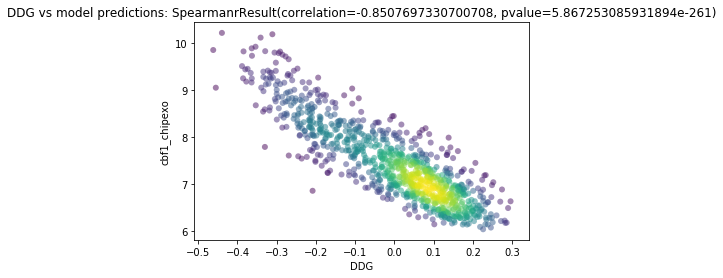

cbf1_pbexo


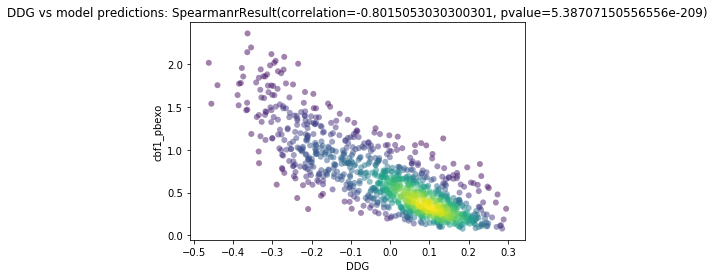

pho4_pbexo


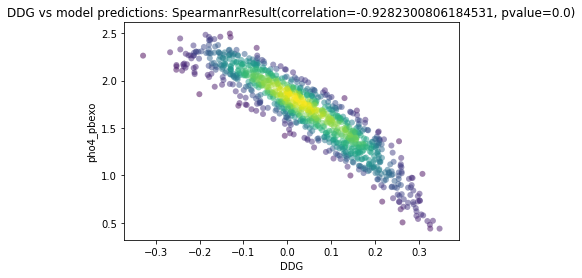

In [11]:
for key in tfToDeltaCountsDict.keys():
    print(key)
    yvals = []
    if "chipexo" in key:
        for flank in genomeFlankToCoord:
            y_1 = np.array(tfToDeltaCountsDict[key][flank]).astype(float)
            yvals.append(np.mean(y_1))
    else:
        for flank in genomeFlankToCoord:
            y_0 = np.array(tfToDeltaCountsDict[key][flank][0]).astype(float)
            y_1 = np.array(tfToDeltaCountsDict[key][flank][1]).astype(float)
            yvals.append(np.mean(y_1-y_0))
    xvals_pho4 = []
    xvals_cbf1 = []
    for flank in genomeFlankToCoord:
        xvals_pho4.append(flankToPho4Ddg[flank])
        xvals_cbf1.append(flankToCbf1Ddg[flank])
    if "pho4" in key:
        xvals = xvals_pho4
    elif "cbf1" in key:
        xvals = xvals_cbf1
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.5)
    plt.xlabel("DDG")
    plt.ylabel(key)
    plt.title("DDG vs model predictions: "+str(spearmanr(xvals, yvals)))
    plt.show()

In [13]:
seq_len = 546
posFootprint = {}
negFootprint = {}
for key in tfToBigWigs.keys():
    posFootprint[key] = {}
    negFootprint[key] = {}
    for flank in genomeFlankToCoord:
        currentPosCounts= []
        currentNegCounts = []
        for chrm, center in genomeFlankToCoord[flank]: 
            start = int(center-(seq_len/2))
            end = int(center+(seq_len/2))
            posvals = np.array(tfToBigWigs[key][0].values(chrm, start, end))
            where_are_NaNs = np.isnan(posvals)
            posvals[where_are_NaNs] = 0.0
            currentPosCounts.append(posvals)
            negvals = np.array(tfToBigWigs[key][1].values(chrm, start, end))
            where_are_NaNs = np.isnan(negvals)
            negvals[where_are_NaNs] = 0.0
            currentNegCounts.append(negvals)
        posFootprint[key][flank] = np.mean(np.array(currentPosCounts), axis = 0)
        negFootprint[key][flank] = np.mean(np.array(currentNegCounts), axis = 0)
    print(key)
    print(len(posFootprint[key]))

cbf1_chipexo
928
cbf1_pbexo
928
pho4_pbexo
928


In [14]:
%matplotlib inline

def plotCorrs(xvals, yvals, xlabel, ylabel):
    xy = np.vstack([xvals,yvals])
    z = gaussian_kde(xy)(xy)
    smallFont = {'size' : 10}
    plt.rc('font', **smallFont)
    fig, ax = plt.subplots()
    ax.scatter(xvals, yvals, c=z, edgecolor='', alpha=0.1)
    axes = plt.gca()
    p, residuals, _, _, _ = np.polyfit(xvals, yvals, 1, full=True)
    m, b = p
    X_plot = np.linspace(axes.get_xlim()[0],axes.get_xlim()[1],100)
    plt.plot(X_plot, m*X_plot + b, '-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("spearman: "+str(spearmanr(xvals, yvals))+
              ", pearson: "+str(pearsonr(xvals, yvals))+
              ", residuals: "+str(residuals))
    plt.show()

In [15]:
def getDDGs(tf, Flanks):
    if "pho4" in tf:
        tfDict = flankToPho4Ddg
    elif "cbf1" in tf:
        tfDict = flankToCbf1Ddg
    ret = []
    for flank in Flanks:
        ret.append(tfDict[flank])
    return np.array(ret)

cbf1_chipexo
16


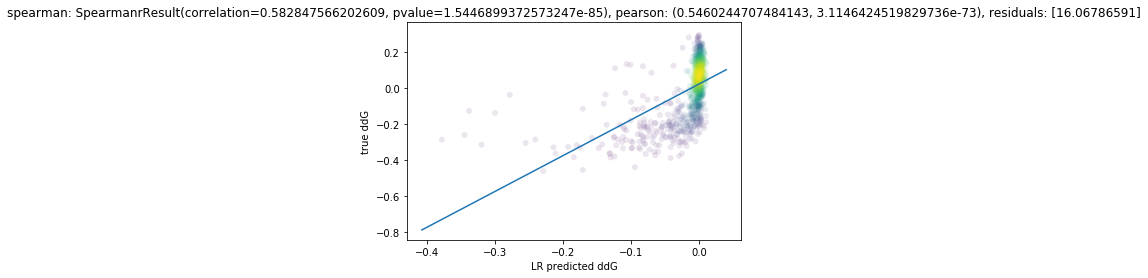

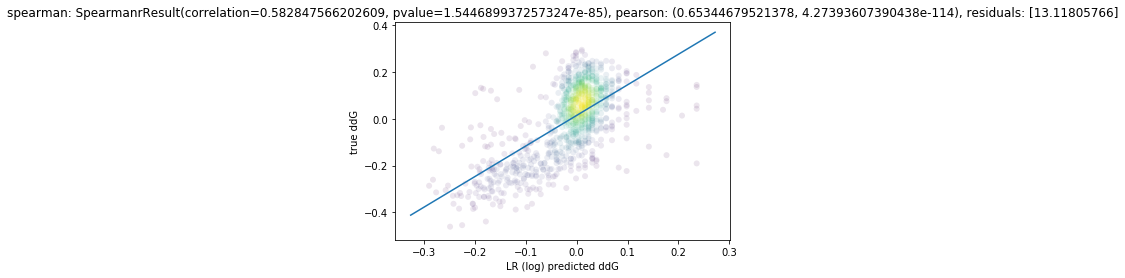

         Current function value: 3010.060330
         Iterations: 173
         Function evaluations: 1321
         Gradient evaluations: 264
         Current function value: 3010.060330
         Iterations: 173
         Function evaluations: 1321
         Gradient evaluations: 264
         Current function value: 3010.060330
         Iterations: 173
         Function evaluations: 1321
         Gradient evaluations: 264
         Current function value: 3010.060330
         Iterations: 173
         Function evaluations: 1321
         Gradient evaluations: 264
         Current function value: 3010.060330
         Iterations: 173
         Function evaluations: 1321
         Gradient evaluations: 264
         Current function value: 3010.060330
         Iterations: 173
         Function evaluations: 1321
         Gradient evaluations: 264
         Current function value: 3010.060330
         Iterations: 173
         Function evaluations: 1321
         Gradient evaluations: 264
         Curr

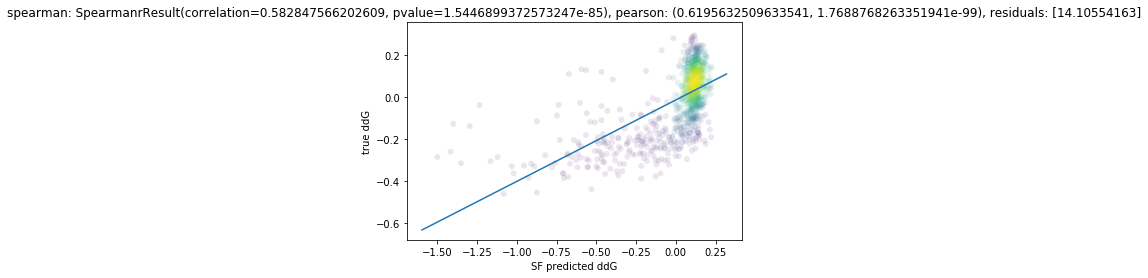

         Current function value: 0.534431
         Iterations: 452
         Function evaluations: 3402
         Gradient evaluations: 678
         Current function value: 0.534431
         Iterations: 452
         Function evaluations: 3402
         Gradient evaluations: 678
         Current function value: 0.534431
         Iterations: 452
         Function evaluations: 3402
         Gradient evaluations: 678
         Current function value: 0.534431
         Iterations: 452
         Function evaluations: 3402
         Gradient evaluations: 678
         Current function value: 0.534431
         Iterations: 452
         Function evaluations: 3402
         Gradient evaluations: 678
         Current function value: 0.534431
         Iterations: 452
         Function evaluations: 3402
         Gradient evaluations: 678
         Current function value: 0.534431
         Iterations: 452
         Function evaluations: 3402
         Gradient evaluations: 678
         Current function value: 0

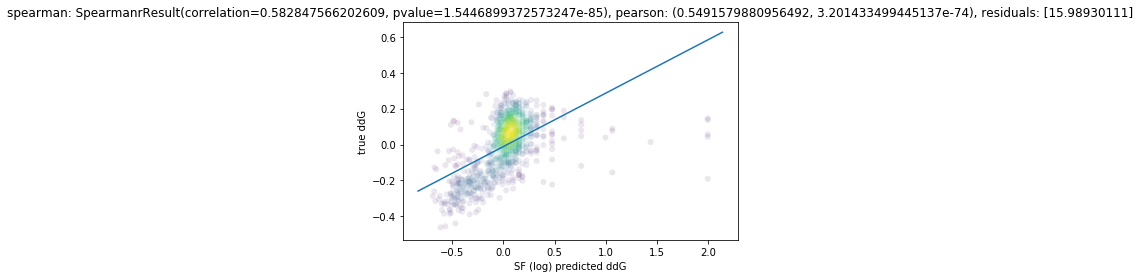

32


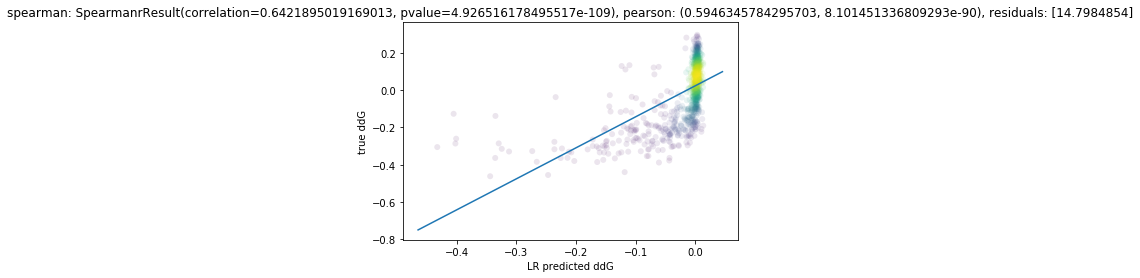

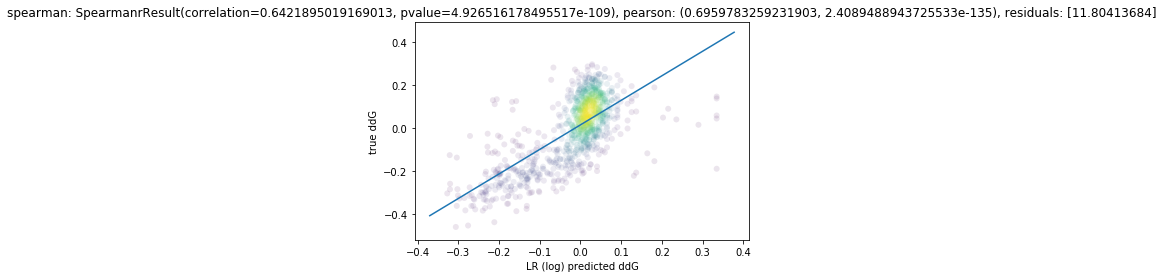

         Current function value: 14088.852881
         Iterations: 124
         Function evaluations: 1322
         Gradient evaluations: 262
         Current function value: 14088.852881
         Iterations: 124
         Function evaluations: 1322
         Gradient evaluations: 262
         Current function value: 14088.852881
         Iterations: 124
         Function evaluations: 1322
         Gradient evaluations: 262
         Current function value: 14088.852881
         Iterations: 124
         Function evaluations: 1322
         Gradient evaluations: 262
         Current function value: 14088.852881
         Iterations: 124
         Function evaluations: 1322
         Gradient evaluations: 262
         Current function value: 14088.852881
         Iterations: 124
         Function evaluations: 1322
         Gradient evaluations: 262
         Current function value: 14088.852881
         Iterations: 124
         Function evaluations: 1322
         Gradient evaluations: 262
      

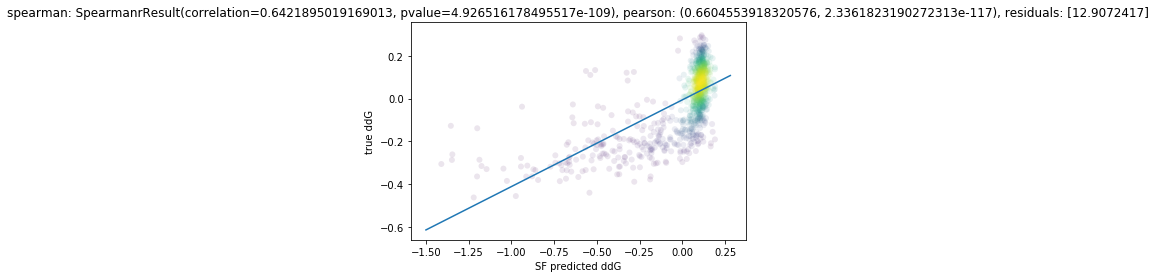

         Current function value: 0.484329
         Iterations: 419
         Function evaluations: 2886
         Gradient evaluations: 577
         Current function value: 0.484329
         Iterations: 419
         Function evaluations: 2886
         Gradient evaluations: 577
         Current function value: 0.484329
         Iterations: 419
         Function evaluations: 2886
         Gradient evaluations: 577
         Current function value: 0.484329
         Iterations: 419
         Function evaluations: 2886
         Gradient evaluations: 577
         Current function value: 0.484329
         Iterations: 419
         Function evaluations: 2886
         Gradient evaluations: 577
         Current function value: 0.484329
         Iterations: 419
         Function evaluations: 2886
         Gradient evaluations: 577
         Current function value: 0.484329
         Iterations: 419
         Function evaluations: 2886
         Gradient evaluations: 577
         Current function value: 0

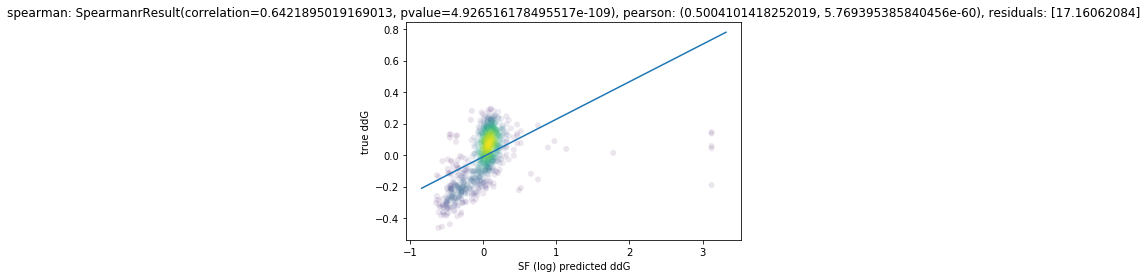

48


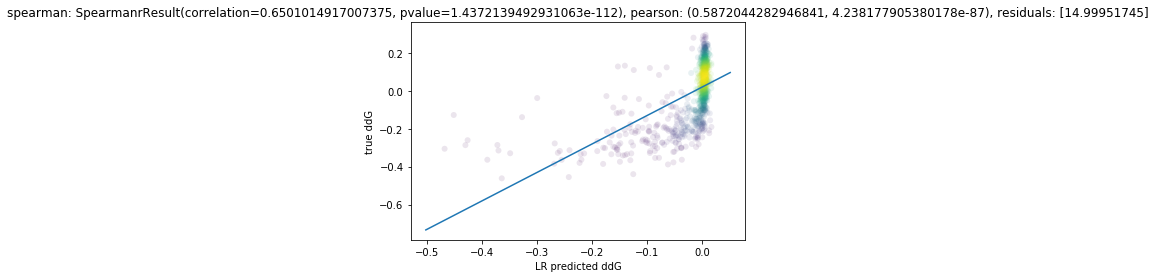

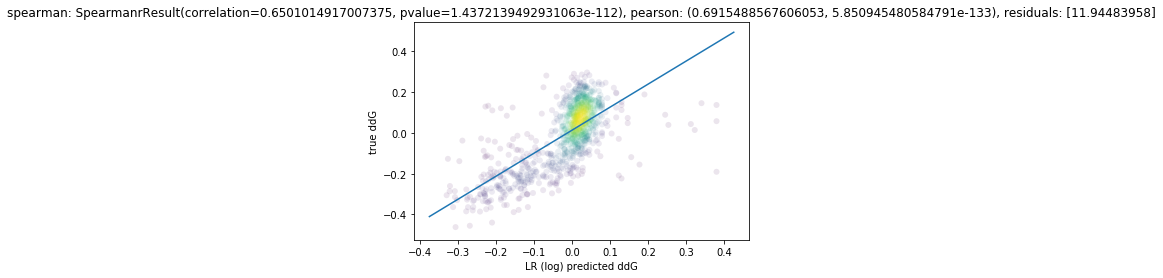

         Current function value: 24329.533215
         Iterations: 123
         Function evaluations: 936
         Gradient evaluations: 187
         Current function value: 24329.533215
         Iterations: 123
         Function evaluations: 936
         Gradient evaluations: 187
         Current function value: 24329.533215
         Iterations: 123
         Function evaluations: 936
         Gradient evaluations: 187
         Current function value: 24329.533215
         Iterations: 123
         Function evaluations: 936
         Gradient evaluations: 187
         Current function value: 24329.533215
         Iterations: 123
         Function evaluations: 936
         Gradient evaluations: 187
         Current function value: 24329.533215
         Iterations: 123
         Function evaluations: 936
         Gradient evaluations: 187
         Current function value: 24329.533215
         Iterations: 123
         Function evaluations: 936
         Gradient evaluations: 187
         Curr

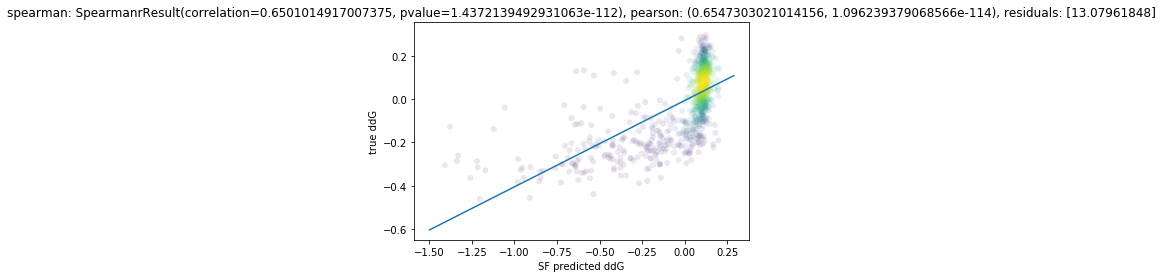

         Current function value: 0.459160
         Iterations: 437
         Function evaluations: 3201
         Gradient evaluations: 640
         Current function value: 0.459160
         Iterations: 437
         Function evaluations: 3201
         Gradient evaluations: 640
         Current function value: 0.459160
         Iterations: 437
         Function evaluations: 3201
         Gradient evaluations: 640
         Current function value: 0.459160
         Iterations: 437
         Function evaluations: 3201
         Gradient evaluations: 640
         Current function value: 0.459160
         Iterations: 437
         Function evaluations: 3201
         Gradient evaluations: 640
         Current function value: 0.459160
         Iterations: 437
         Function evaluations: 3201
         Gradient evaluations: 640
         Current function value: 0.459160
         Iterations: 437
         Function evaluations: 3201
         Gradient evaluations: 640
         Current function value: 0

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


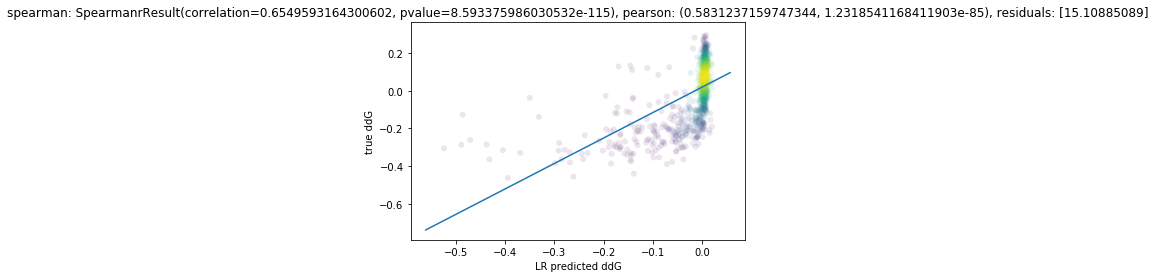

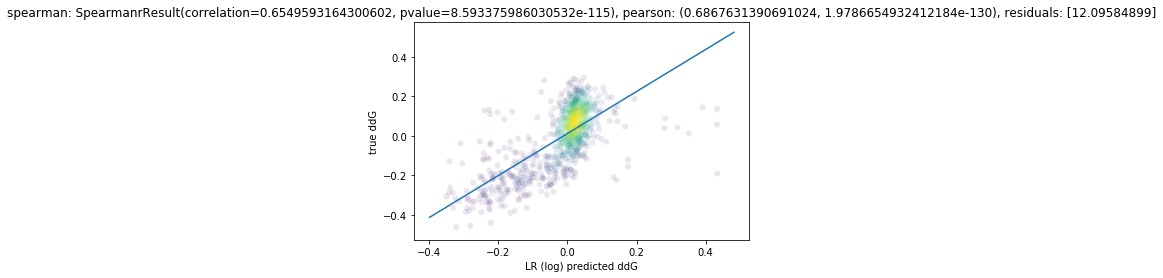

         Current function value: 34064.816094
         Iterations: 148
         Function evaluations: 1186
         Gradient evaluations: 237
         Current function value: 34064.816094
         Iterations: 148
         Function evaluations: 1186
         Gradient evaluations: 237
         Current function value: 34064.816094
         Iterations: 148
         Function evaluations: 1186
         Gradient evaluations: 237
         Current function value: 34064.816094
         Iterations: 148
         Function evaluations: 1186
         Gradient evaluations: 237
         Current function value: 34064.816094
         Iterations: 148
         Function evaluations: 1186
         Gradient evaluations: 237
         Current function value: 34064.816094
         Iterations: 148
         Function evaluations: 1186
         Gradient evaluations: 237
         Current function value: 34064.816094
         Iterations: 148
         Function evaluations: 1186
         Gradient evaluations: 237
      

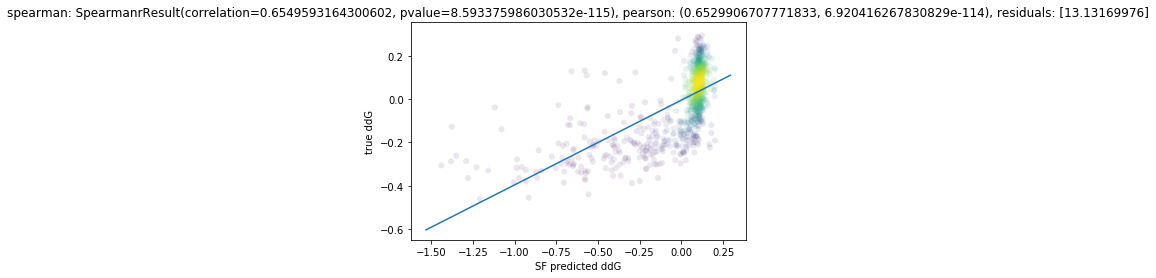

         Current function value: 0.415243
         Iterations: 398
         Function evaluations: 2721
         Gradient evaluations: 544
         Current function value: 0.415243
         Iterations: 398
         Function evaluations: 2721
         Gradient evaluations: 544
         Current function value: 0.415243
         Iterations: 398
         Function evaluations: 2721
         Gradient evaluations: 544
         Current function value: 0.415243
         Iterations: 398
         Function evaluations: 2721
         Gradient evaluations: 544
         Current function value: 0.415243
         Iterations: 398
         Function evaluations: 2721
         Gradient evaluations: 544
         Current function value: 0.415243
         Iterations: 398
         Function evaluations: 2721
         Gradient evaluations: 544
         Current function value: 0.415243
         Iterations: 398
         Function evaluations: 2721
         Gradient evaluations: 544
         Current function value: 0

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


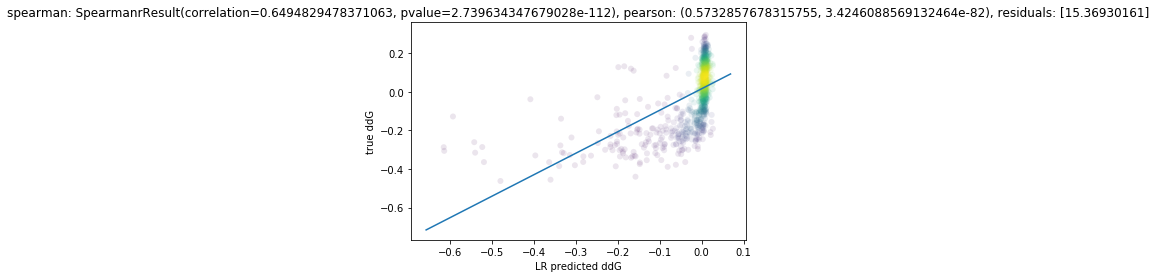

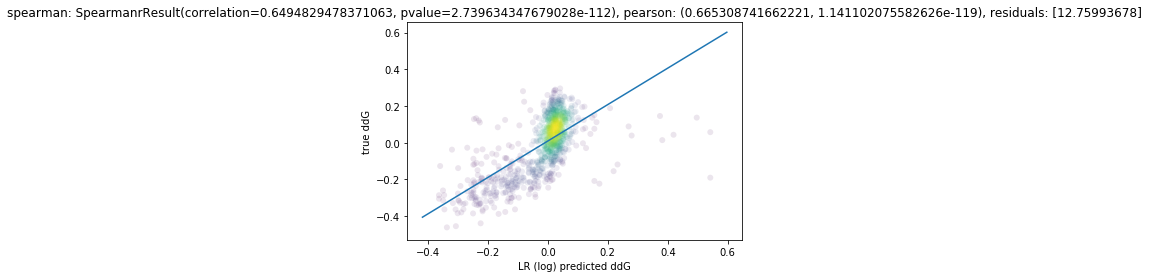

Optimization terminated successfully.
         Current function value: 100712.828100
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 100712.828100
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 100712.828100
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 100712.828100
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 100712.828100
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 100712.828100
         Iterations: 4
         Function

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


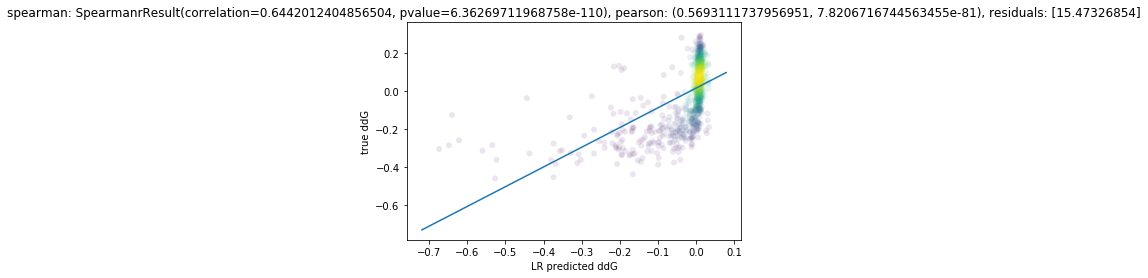

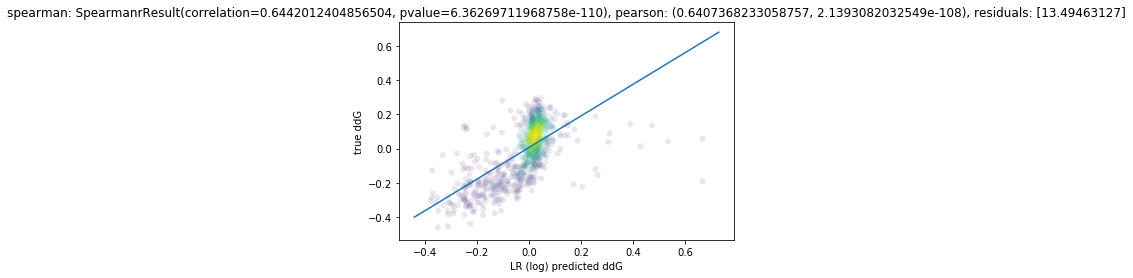

         Current function value: 200940.399765
         Iterations: 116
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 200940.399765
         Iterations: 116
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 200940.399765
         Iterations: 116
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 200940.399765
         Iterations: 116
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 200940.399765
         Iterations: 116
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 200940.399765
         Iterations: 116
         Function evaluations: 886
         Gradient evaluations: 177
         Current function value: 200940.399765
         Iterations: 116
         Function evaluations: 886
         Gradient evaluations: 177
      

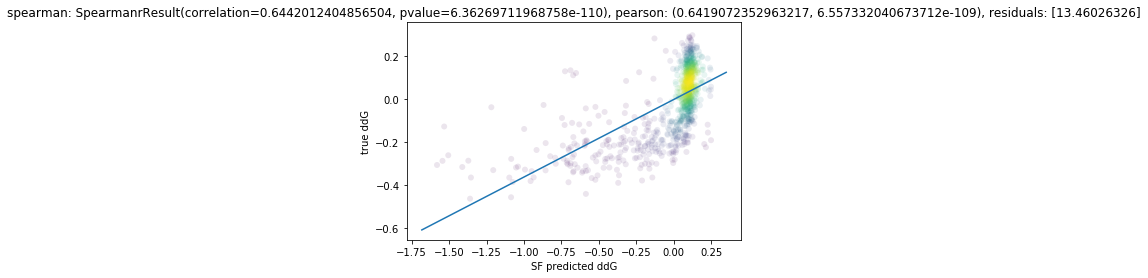

         Current function value: 0.297382
         Iterations: 477
         Function evaluations: 3336
         Gradient evaluations: 667
         Current function value: 0.297382
         Iterations: 477
         Function evaluations: 3336
         Gradient evaluations: 667
         Current function value: 0.297382
         Iterations: 477
         Function evaluations: 3336
         Gradient evaluations: 667
         Current function value: 0.297382
         Iterations: 477
         Function evaluations: 3336
         Gradient evaluations: 667
         Current function value: 0.297382
         Iterations: 477
         Function evaluations: 3336
         Gradient evaluations: 667
         Current function value: 0.297382
         Iterations: 477
         Function evaluations: 3336
         Gradient evaluations: 667
         Current function value: 0.297382
         Iterations: 477
         Function evaluations: 3336
         Gradient evaluations: 667
         Current function value: 0

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


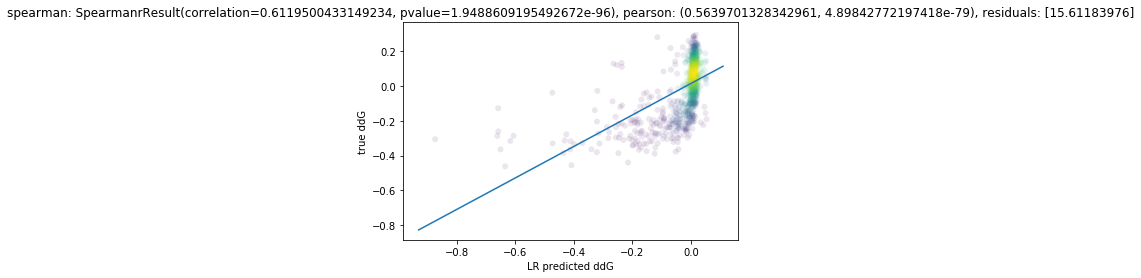

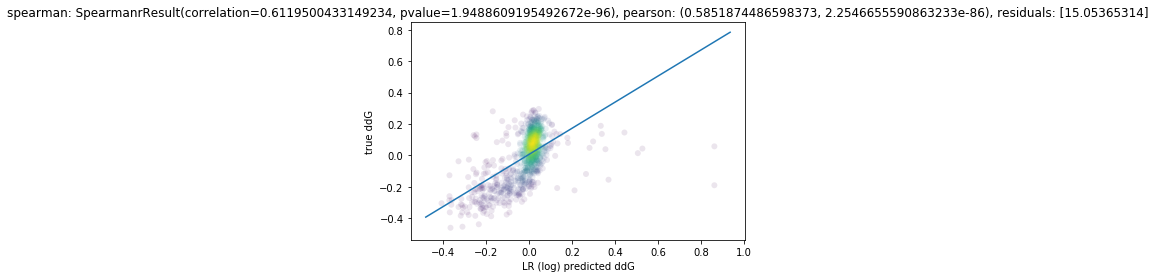

Optimization terminated successfully.
         Current function value: 396522.632399
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 396522.632399
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 396522.632399
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 396522.632399
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 396522.632399
         Iterations: 4
         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 396522.632399
         Iterations: 4
         Fun

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


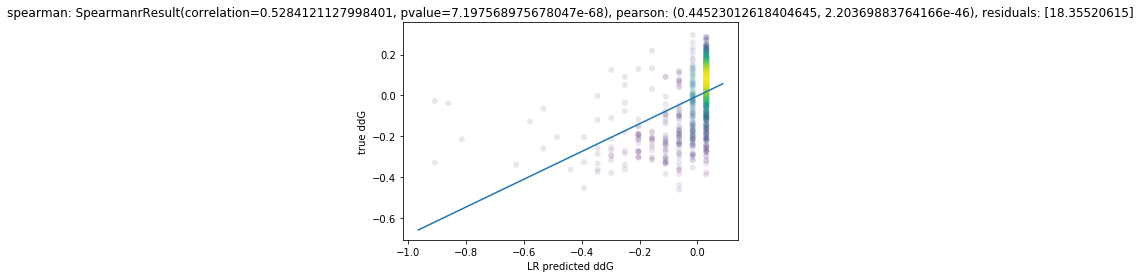

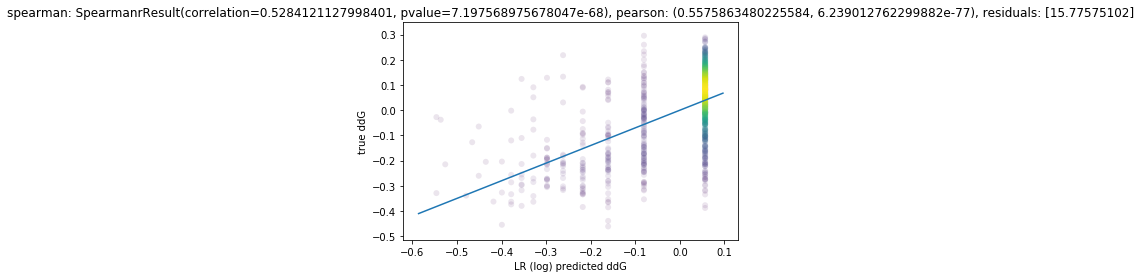

         Current function value: 2.706913
         Iterations: 325
         Function evaluations: 2522
         Gradient evaluations: 502
         Current function value: 2.706913
         Iterations: 325
         Function evaluations: 2522
         Gradient evaluations: 502
         Current function value: 2.706913
         Iterations: 325
         Function evaluations: 2522
         Gradient evaluations: 502
         Current function value: 2.706913
         Iterations: 325
         Function evaluations: 2522
         Gradient evaluations: 502
         Current function value: 2.706913
         Iterations: 325
         Function evaluations: 2522
         Gradient evaluations: 502
         Current function value: 2.706913
         Iterations: 325
         Function evaluations: 2522
         Gradient evaluations: 502
         Current function value: 2.706913
         Iterations: 325
         Function evaluations: 2522
         Gradient evaluations: 502
         Current function value: 2

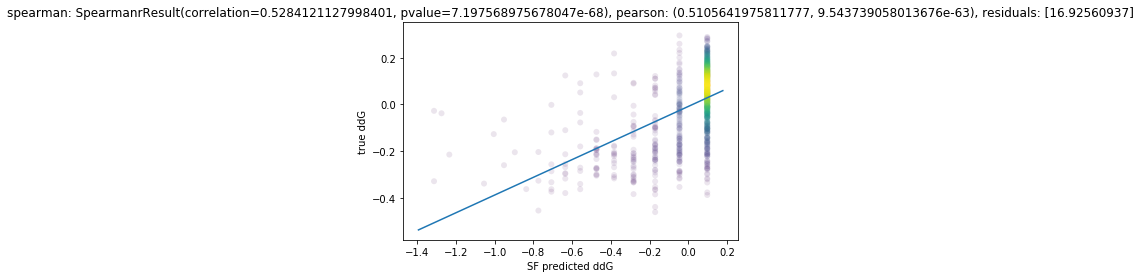

         Current function value: 0.164389
         Iterations: 447
         Function evaluations: 3181
         Gradient evaluations: 636
         Current function value: 0.164389
         Iterations: 447
         Function evaluations: 3181
         Gradient evaluations: 636
         Current function value: 0.164389
         Iterations: 447
         Function evaluations: 3181
         Gradient evaluations: 636
         Current function value: 0.164389
         Iterations: 447
         Function evaluations: 3181
         Gradient evaluations: 636
         Current function value: 0.164389
         Iterations: 447
         Function evaluations: 3181
         Gradient evaluations: 636
         Current function value: 0.164389
         Iterations: 447
         Function evaluations: 3181
         Gradient evaluations: 636
         Current function value: 0.164389
         Iterations: 447
         Function evaluations: 3181
         Gradient evaluations: 636
         Current function value: 0

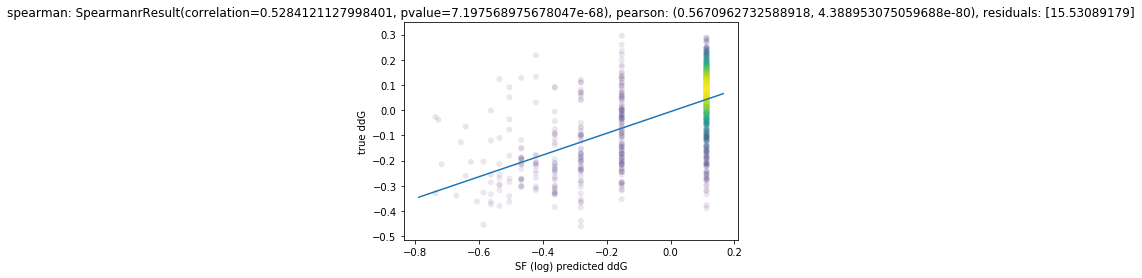

32


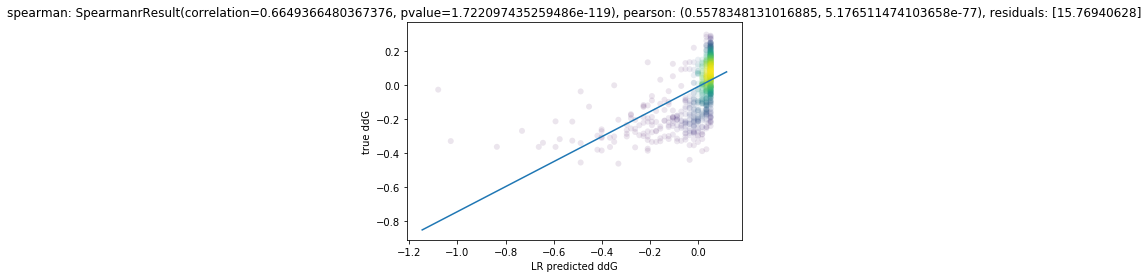

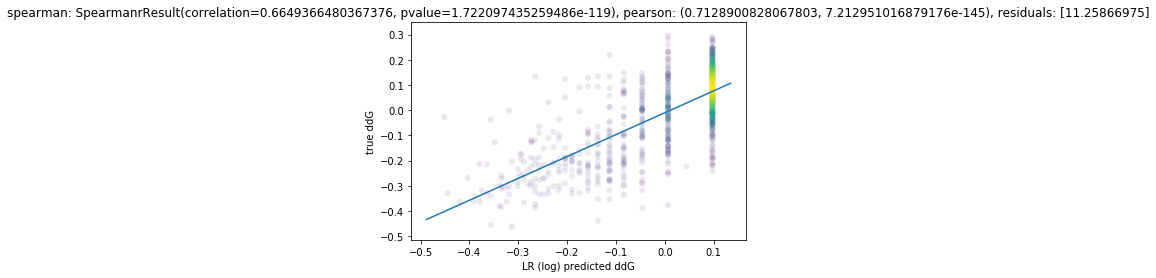

         Current function value: 21.152119
         Iterations: 270
         Function evaluations: 1906
         Gradient evaluations: 381
         Current function value: 21.152119
         Iterations: 270
         Function evaluations: 1906
         Gradient evaluations: 381
         Current function value: 21.152119
         Iterations: 270
         Function evaluations: 1906
         Gradient evaluations: 381
         Current function value: 21.152119
         Iterations: 270
         Function evaluations: 1906
         Gradient evaluations: 381
         Current function value: 21.152119
         Iterations: 270
         Function evaluations: 1906
         Gradient evaluations: 381
         Current function value: 21.152119
         Iterations: 270
         Function evaluations: 1906
         Gradient evaluations: 381
         Current function value: 21.152119
         Iterations: 270
         Function evaluations: 1906
         Gradient evaluations: 381
         Current function v

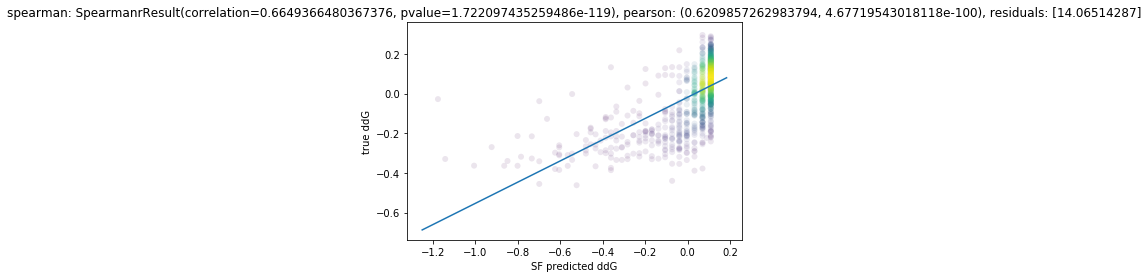

         Current function value: 0.323293
         Iterations: 488
         Function evaluations: 3366
         Gradient evaluations: 673
         Current function value: 0.323293
         Iterations: 488
         Function evaluations: 3366
         Gradient evaluations: 673
         Current function value: 0.323293
         Iterations: 488
         Function evaluations: 3366
         Gradient evaluations: 673
         Current function value: 0.323293
         Iterations: 488
         Function evaluations: 3366
         Gradient evaluations: 673
         Current function value: 0.323293
         Iterations: 488
         Function evaluations: 3366
         Gradient evaluations: 673
         Current function value: 0.323293
         Iterations: 488
         Function evaluations: 3366
         Gradient evaluations: 673
         Current function value: 0.323293
         Iterations: 488
         Function evaluations: 3366
         Gradient evaluations: 673
         Current function value: 0

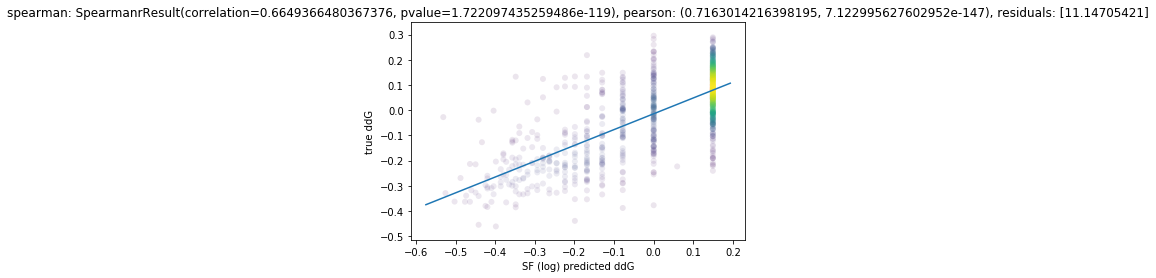

48


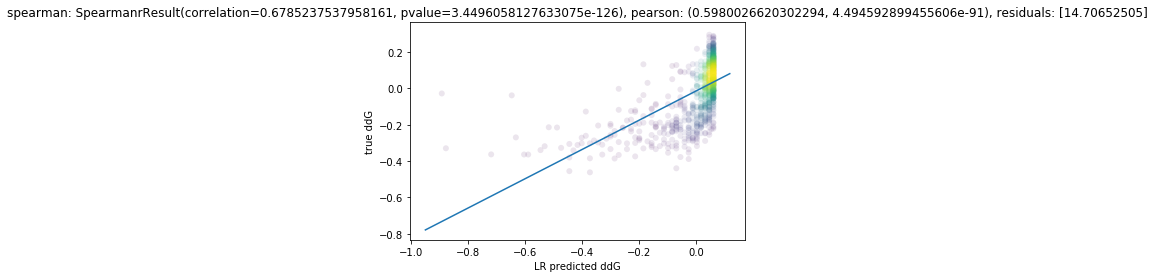

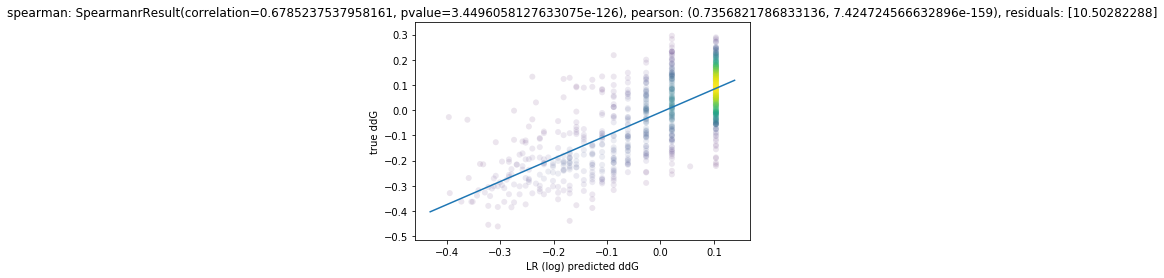

         Current function value: 30.051054
         Iterations: 266
         Function evaluations: 2006
         Gradient evaluations: 401
         Current function value: 30.051054
         Iterations: 266
         Function evaluations: 2006
         Gradient evaluations: 401
         Current function value: 30.051054
         Iterations: 266
         Function evaluations: 2006
         Gradient evaluations: 401
         Current function value: 30.051054
         Iterations: 266
         Function evaluations: 2006
         Gradient evaluations: 401
         Current function value: 30.051054
         Iterations: 266
         Function evaluations: 2006
         Gradient evaluations: 401
         Current function value: 30.051054
         Iterations: 266
         Function evaluations: 2006
         Gradient evaluations: 401
         Current function value: 30.051054
         Iterations: 266
         Function evaluations: 2006
         Gradient evaluations: 401
         Current function v

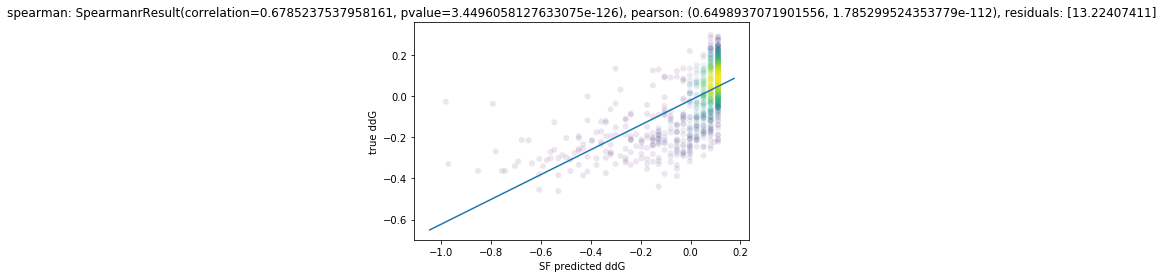

         Current function value: 0.380579
         Iterations: 439
         Function evaluations: 3111
         Gradient evaluations: 622
         Current function value: 0.380579
         Iterations: 439
         Function evaluations: 3111
         Gradient evaluations: 622
         Current function value: 0.380579
         Iterations: 439
         Function evaluations: 3111
         Gradient evaluations: 622
         Current function value: 0.380579
         Iterations: 439
         Function evaluations: 3111
         Gradient evaluations: 622
         Current function value: 0.380579
         Iterations: 439
         Function evaluations: 3111
         Gradient evaluations: 622
         Current function value: 0.380579
         Iterations: 439
         Function evaluations: 3111
         Gradient evaluations: 622
         Current function value: 0.380579
         Iterations: 439
         Function evaluations: 3111
         Gradient evaluations: 622
         Current function value: 0

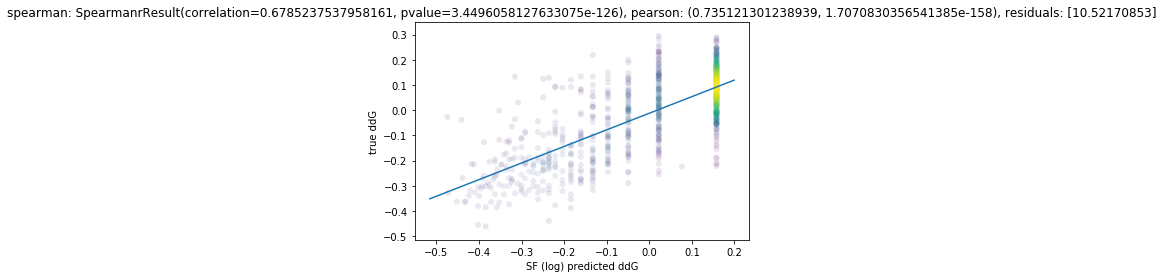

64


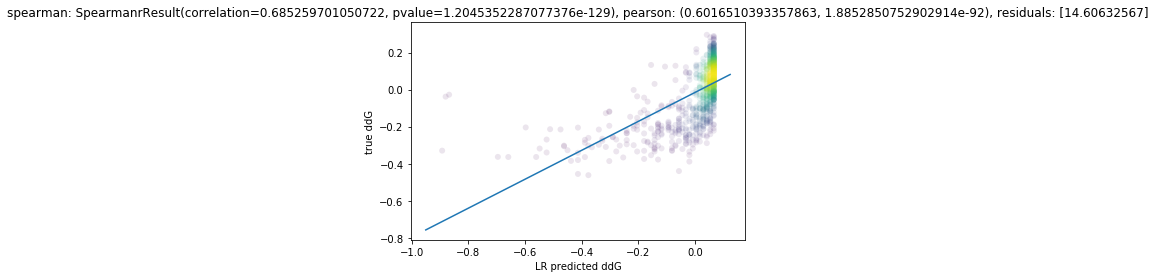

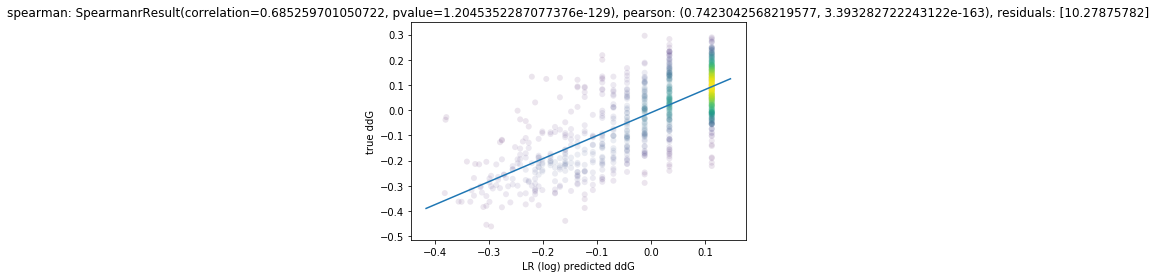

         Current function value: 39.252611
         Iterations: 297
         Function evaluations: 2401
         Gradient evaluations: 478
         Current function value: 39.252611
         Iterations: 297
         Function evaluations: 2401
         Gradient evaluations: 478
         Current function value: 39.252611
         Iterations: 297
         Function evaluations: 2401
         Gradient evaluations: 478
         Current function value: 39.252611
         Iterations: 297
         Function evaluations: 2401
         Gradient evaluations: 478
         Current function value: 39.252611
         Iterations: 297
         Function evaluations: 2401
         Gradient evaluations: 478
         Current function value: 39.252611
         Iterations: 297
         Function evaluations: 2401
         Gradient evaluations: 478
         Current function value: 39.252611
         Iterations: 297
         Function evaluations: 2401
         Gradient evaluations: 478
         Current function v

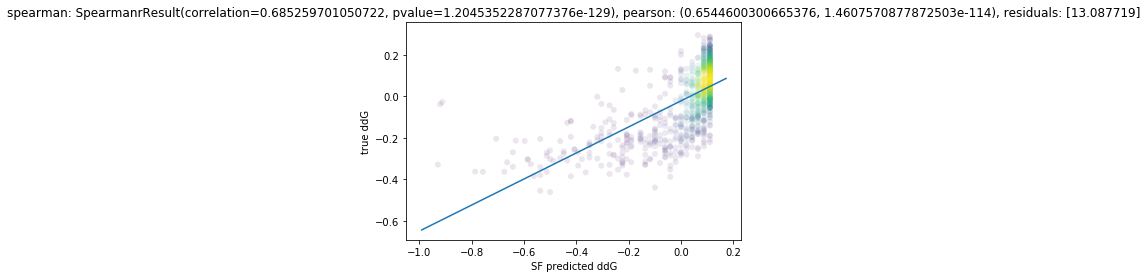

         Current function value: 0.398399
         Iterations: 437
         Function evaluations: 3267
         Gradient evaluations: 651
         Current function value: 0.398399
         Iterations: 437
         Function evaluations: 3267
         Gradient evaluations: 651
         Current function value: 0.398399
         Iterations: 437
         Function evaluations: 3267
         Gradient evaluations: 651
         Current function value: 0.398399
         Iterations: 437
         Function evaluations: 3267
         Gradient evaluations: 651
         Current function value: 0.398399
         Iterations: 437
         Function evaluations: 3267
         Gradient evaluations: 651
         Current function value: 0.398399
         Iterations: 437
         Function evaluations: 3267
         Gradient evaluations: 651
         Current function value: 0.398399
         Iterations: 437
         Function evaluations: 3267
         Gradient evaluations: 651
         Current function value: 0

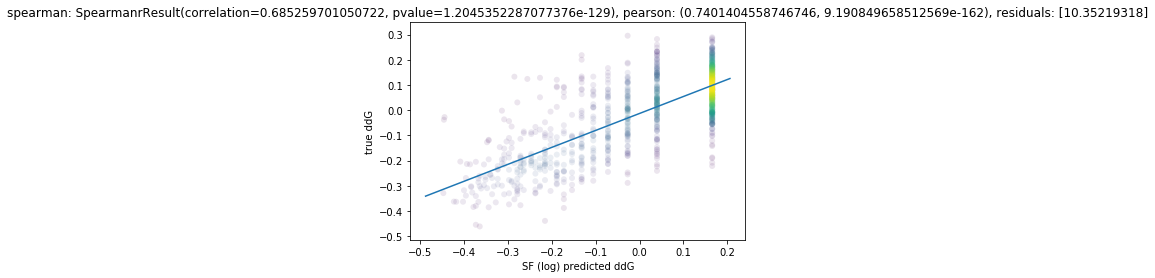

128


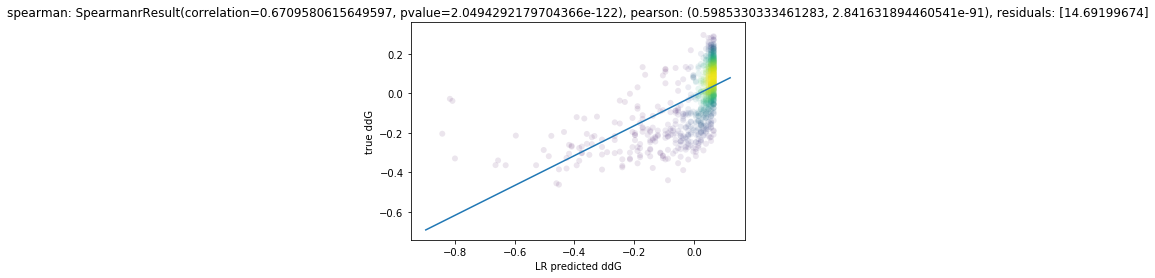

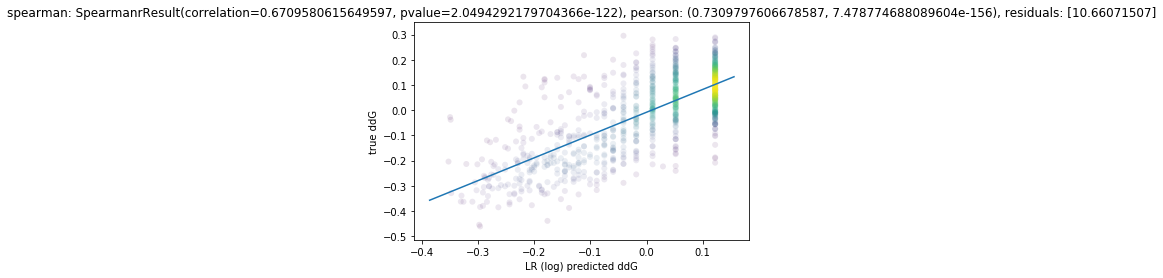

         Current function value: 84.496033
         Iterations: 258
         Function evaluations: 2292
         Gradient evaluations: 456
         Current function value: 84.496033
         Iterations: 258
         Function evaluations: 2292
         Gradient evaluations: 456
         Current function value: 84.496033
         Iterations: 258
         Function evaluations: 2292
         Gradient evaluations: 456
         Current function value: 84.496033
         Iterations: 258
         Function evaluations: 2292
         Gradient evaluations: 456
         Current function value: 84.496033
         Iterations: 258
         Function evaluations: 2292
         Gradient evaluations: 456
         Current function value: 84.496033
         Iterations: 258
         Function evaluations: 2292
         Gradient evaluations: 456
         Current function value: 84.496033
         Iterations: 258
         Function evaluations: 2292
         Gradient evaluations: 456
         Current function v

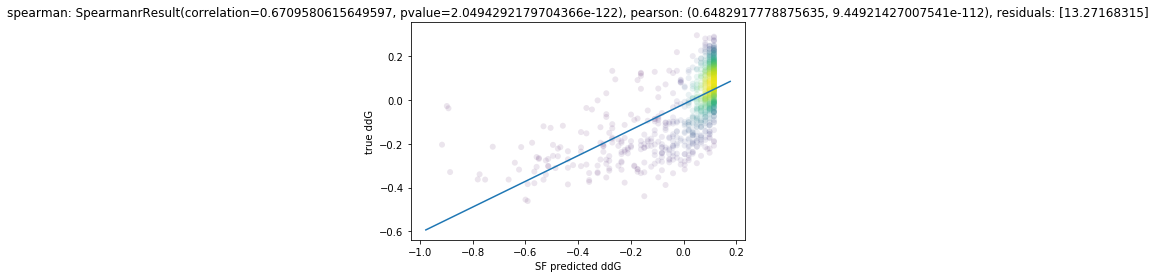

         Current function value: 0.544796
         Iterations: 461
         Function evaluations: 3311
         Gradient evaluations: 662
         Current function value: 0.544796
         Iterations: 461
         Function evaluations: 3311
         Gradient evaluations: 662
         Current function value: 0.544796
         Iterations: 461
         Function evaluations: 3311
         Gradient evaluations: 662
         Current function value: 0.544796
         Iterations: 461
         Function evaluations: 3311
         Gradient evaluations: 662
         Current function value: 0.544796
         Iterations: 461
         Function evaluations: 3311
         Gradient evaluations: 662
         Current function value: 0.544796
         Iterations: 461
         Function evaluations: 3311
         Gradient evaluations: 662
         Current function value: 0.544796
         Iterations: 461
         Function evaluations: 3311
         Gradient evaluations: 662
         Current function value: 0

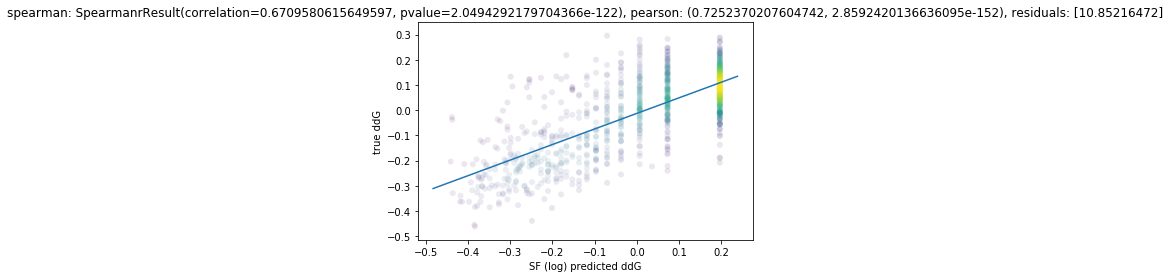

256


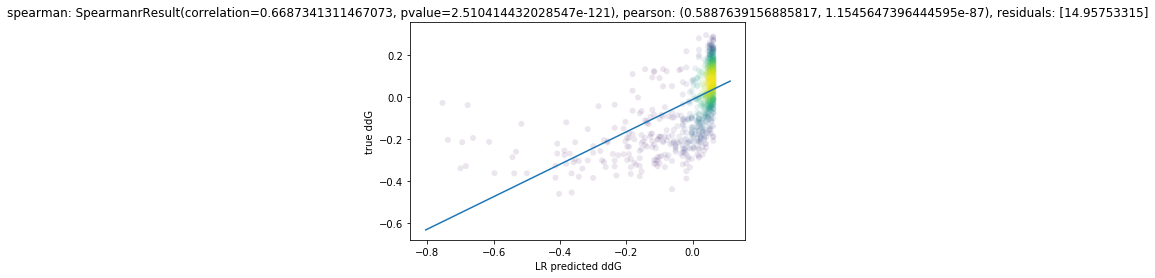

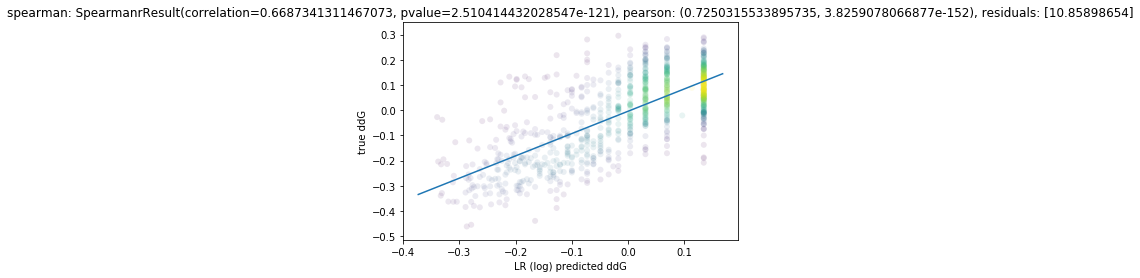

         Current function value: 215.347616
         Iterations: 228
         Function evaluations: 2002
         Gradient evaluations: 398
         Current function value: 215.347616
         Iterations: 228
         Function evaluations: 2002
         Gradient evaluations: 398
         Current function value: 215.347616
         Iterations: 228
         Function evaluations: 2002
         Gradient evaluations: 398
         Current function value: 215.347616
         Iterations: 228
         Function evaluations: 2002
         Gradient evaluations: 398
         Current function value: 215.347616
         Iterations: 228
         Function evaluations: 2002
         Gradient evaluations: 398
         Current function value: 215.347616
         Iterations: 228
         Function evaluations: 2002
         Gradient evaluations: 398
         Current function value: 215.347616
         Iterations: 228
         Function evaluations: 2002
         Gradient evaluations: 398
         Current fun

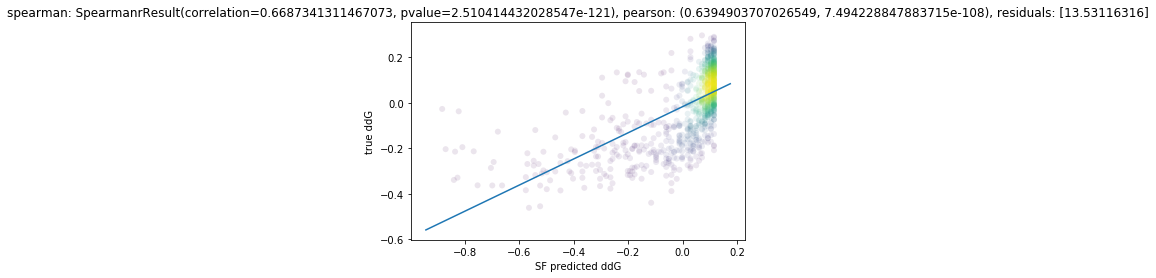

         Current function value: 0.618402
         Iterations: 416
         Function evaluations: 3032
         Gradient evaluations: 604
         Current function value: 0.618402
         Iterations: 416
         Function evaluations: 3032
         Gradient evaluations: 604
         Current function value: 0.618402
         Iterations: 416
         Function evaluations: 3032
         Gradient evaluations: 604
         Current function value: 0.618402
         Iterations: 416
         Function evaluations: 3032
         Gradient evaluations: 604
         Current function value: 0.618402
         Iterations: 416
         Function evaluations: 3032
         Gradient evaluations: 604
         Current function value: 0.618402
         Iterations: 416
         Function evaluations: 3032
         Gradient evaluations: 604
         Current function value: 0.618402
         Iterations: 416
         Function evaluations: 3032
         Gradient evaluations: 604
         Current function value: 0

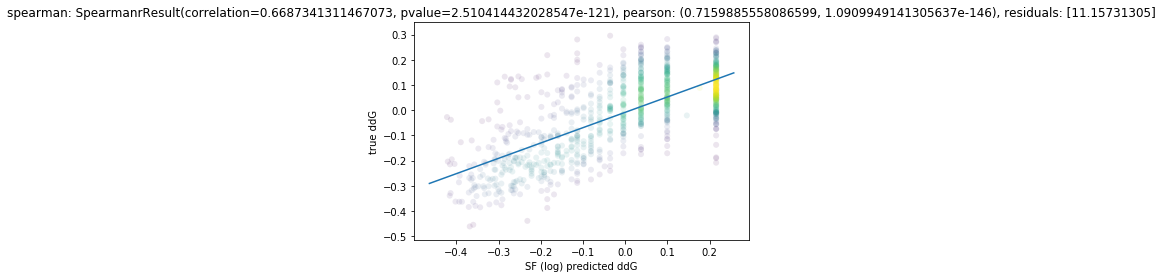

546


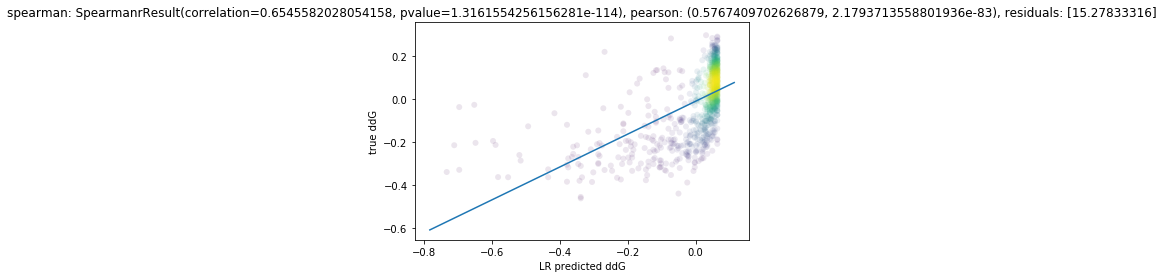

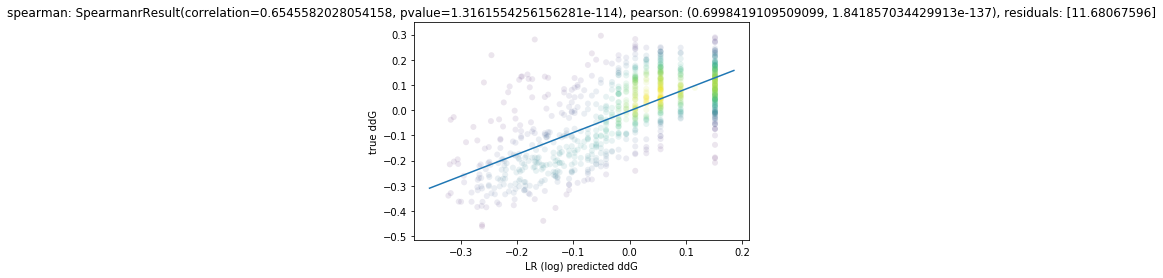

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351


/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


         Current function value: 460.518439
         Iterations: 194
         Function evaluations: 1767
         Gradient evaluations: 351
multiplier:  26846.396379735685 , in sigmoid bias:  -5.194064040372986 , out of sigmoid bias:  -131.94298916184977


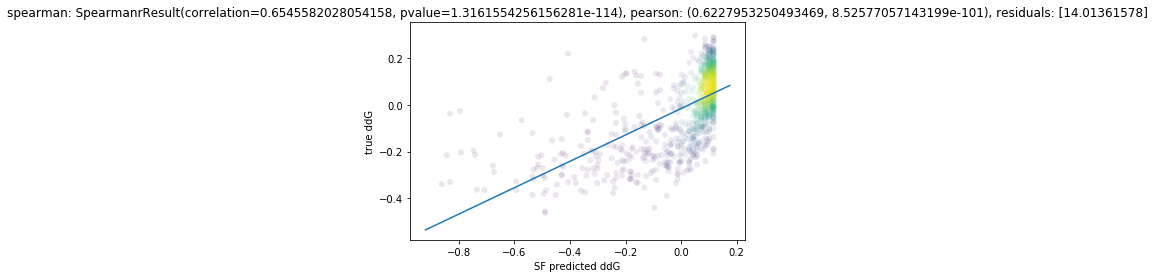

         Current function value: 0.739215
         Iterations: 456
         Function evaluations: 3071
         Gradient evaluations: 614
         Current function value: 0.739215
         Iterations: 456
         Function evaluations: 3071
         Gradient evaluations: 614
         Current function value: 0.739215
         Iterations: 456
         Function evaluations: 3071
         Gradient evaluations: 614
         Current function value: 0.739215
         Iterations: 456
         Function evaluations: 3071
         Gradient evaluations: 614
         Current function value: 0.739215
         Iterations: 456
         Function evaluations: 3071
         Gradient evaluations: 614
         Current function value: 0.739215
         Iterations: 456
         Function evaluations: 3071
         Gradient evaluations: 614
         Current function value: 0.739215
         Iterations: 456
         Function evaluations: 3071
         Gradient evaluations: 614
         Current function value: 0

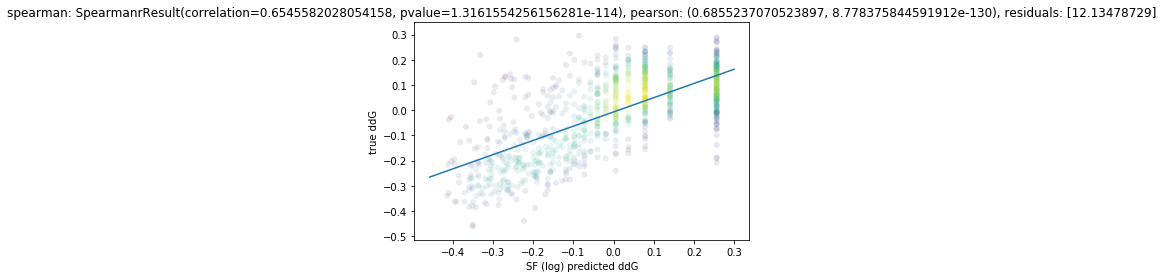

pho4_pbexo
16


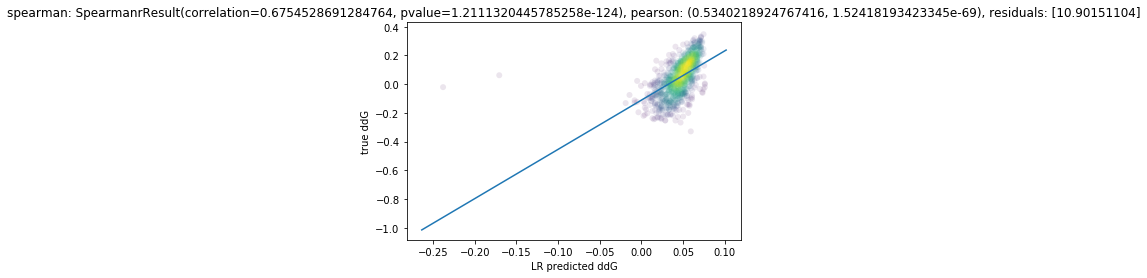

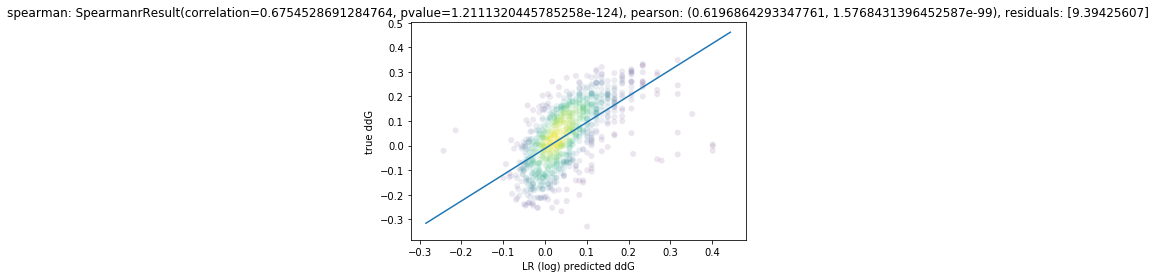

         Current function value: 454.260480
         Iterations: 226
         Function evaluations: 1892
         Gradient evaluations: 376
         Current function value: 454.260480
         Iterations: 226
         Function evaluations: 1892
         Gradient evaluations: 376
         Current function value: 454.260480
         Iterations: 226
         Function evaluations: 1892
         Gradient evaluations: 376
         Current function value: 454.260480
         Iterations: 226
         Function evaluations: 1892
         Gradient evaluations: 376
         Current function value: 454.260480
         Iterations: 226
         Function evaluations: 1892
         Gradient evaluations: 376
         Current function value: 454.260480
         Iterations: 226
         Function evaluations: 1892
         Gradient evaluations: 376
         Current function value: 454.260480
         Iterations: 226
         Function evaluations: 1892
         Gradient evaluations: 376
         Current fun

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


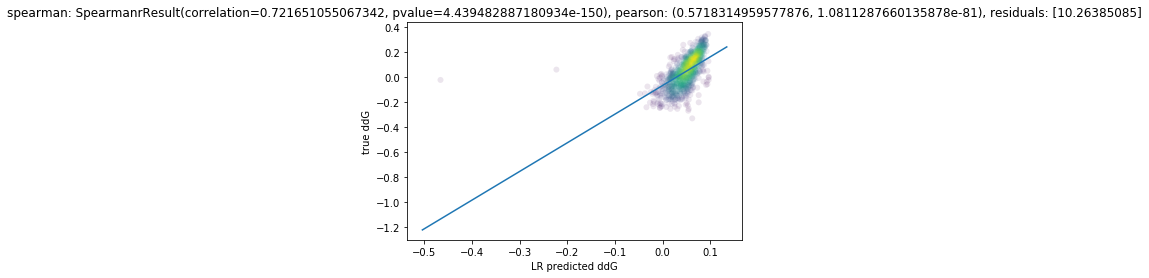

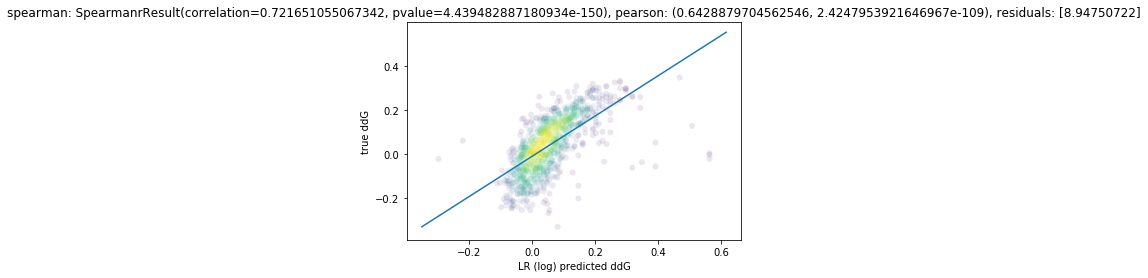

         Current function value: 1577.034838
         Iterations: 130
         Function evaluations: 1445
         Gradient evaluations: 287
         Current function value: 1577.034838
         Iterations: 130
         Function evaluations: 1445
         Gradient evaluations: 287
         Current function value: 1577.034838
         Iterations: 130
         Function evaluations: 1445
         Gradient evaluations: 287
         Current function value: 1577.034838
         Iterations: 130
         Function evaluations: 1445
         Gradient evaluations: 287
         Current function value: 1577.034838
         Iterations: 130
         Function evaluations: 1445
         Gradient evaluations: 287
         Current function value: 1577.034838
         Iterations: 130
         Function evaluations: 1445
         Gradient evaluations: 287
         Current function value: 1577.034838
         Iterations: 130
         Function evaluations: 1445
         Gradient evaluations: 287
         Curr

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


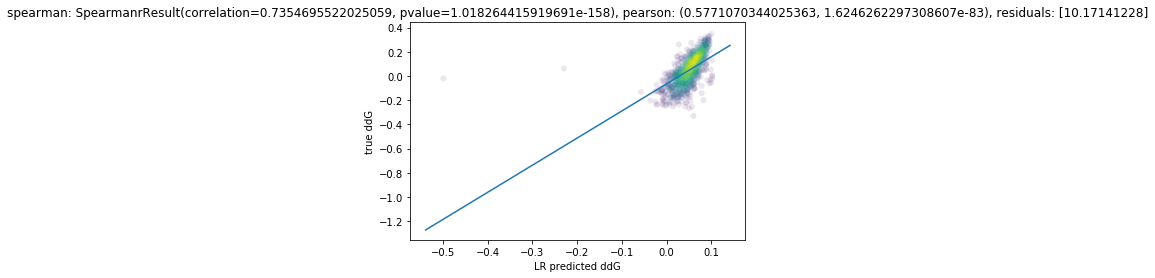

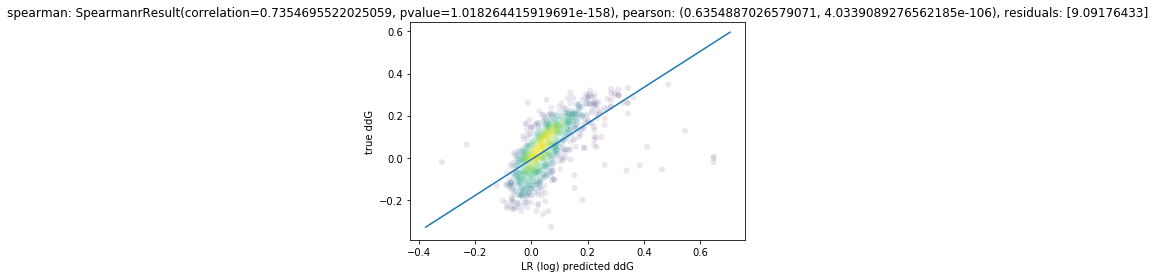

         Current function value: 2560.793961
         Iterations: 177
         Function evaluations: 2168
         Gradient evaluations: 431
         Current function value: 2560.793961
         Iterations: 177
         Function evaluations: 2168
         Gradient evaluations: 431
         Current function value: 2560.793961
         Iterations: 177
         Function evaluations: 2168
         Gradient evaluations: 431
         Current function value: 2560.793961
         Iterations: 177
         Function evaluations: 2168
         Gradient evaluations: 431
         Current function value: 2560.793961
         Iterations: 177
         Function evaluations: 2168
         Gradient evaluations: 431
         Current function value: 2560.793961
         Iterations: 177
         Function evaluations: 2168
         Gradient evaluations: 431
         Current function value: 2560.793961
         Iterations: 177
         Function evaluations: 2168
         Gradient evaluations: 431
         Curr

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


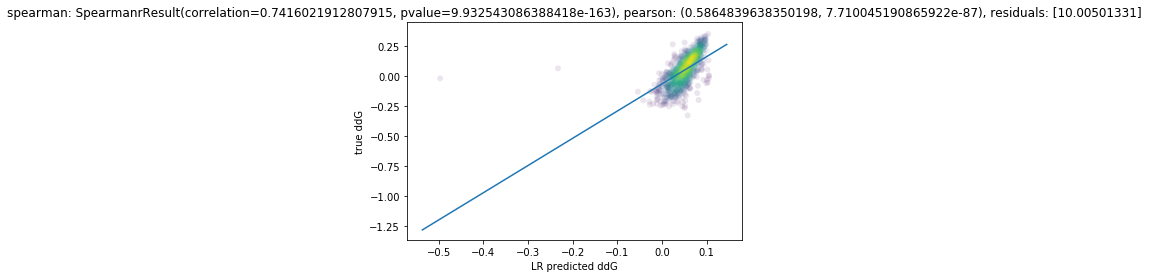

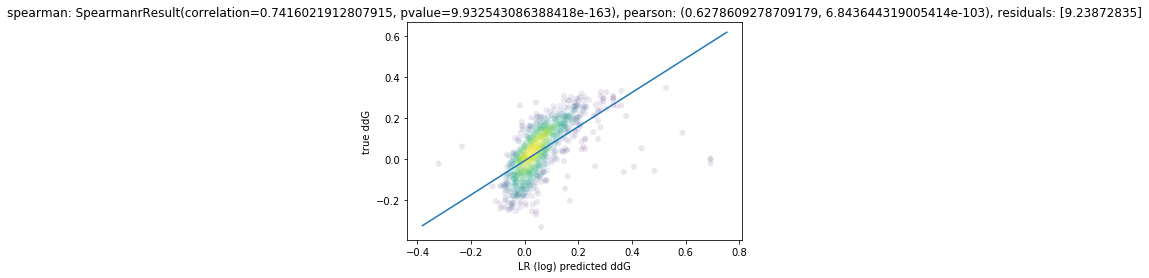

         Current function value: 3317.677619
         Iterations: 190
         Function evaluations: 1612
         Gradient evaluations: 320
         Current function value: 3317.677619
         Iterations: 190
         Function evaluations: 1612
         Gradient evaluations: 320
         Current function value: 3317.677619
         Iterations: 190
         Function evaluations: 1612
         Gradient evaluations: 320
         Current function value: 3317.677619
         Iterations: 190
         Function evaluations: 1612
         Gradient evaluations: 320
         Current function value: 3317.677619
         Iterations: 190
         Function evaluations: 1612
         Gradient evaluations: 320
         Current function value: 3317.677619
         Iterations: 190
         Function evaluations: 1612
         Gradient evaluations: 320
         Current function value: 3317.677619
         Iterations: 190
         Function evaluations: 1612
         Gradient evaluations: 320
         Curr

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


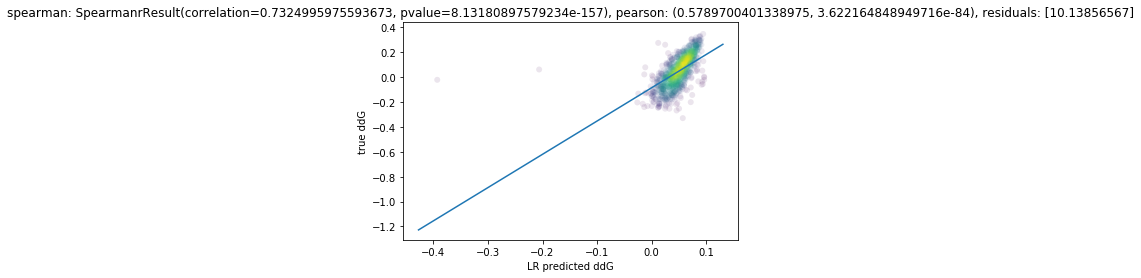

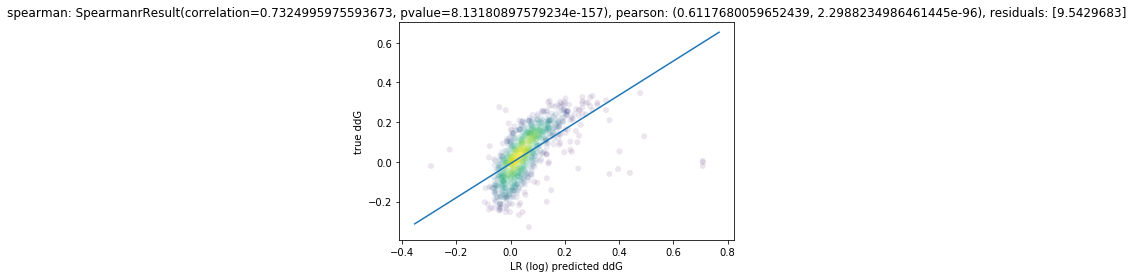

         Current function value: 7219.890298
         Iterations: 160
         Function evaluations: 1776
         Gradient evaluations: 353
         Current function value: 7219.890298
         Iterations: 160
         Function evaluations: 1776
         Gradient evaluations: 353
         Current function value: 7219.890298
         Iterations: 160
         Function evaluations: 1776
         Gradient evaluations: 353
         Current function value: 7219.890298
         Iterations: 160
         Function evaluations: 1776
         Gradient evaluations: 353
         Current function value: 7219.890298
         Iterations: 160
         Function evaluations: 1776
         Gradient evaluations: 353
         Current function value: 7219.890298
         Iterations: 160
         Function evaluations: 1776
         Gradient evaluations: 353
         Current function value: 7219.890298
         Iterations: 160
         Function evaluations: 1776
         Gradient evaluations: 353
         Curr

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


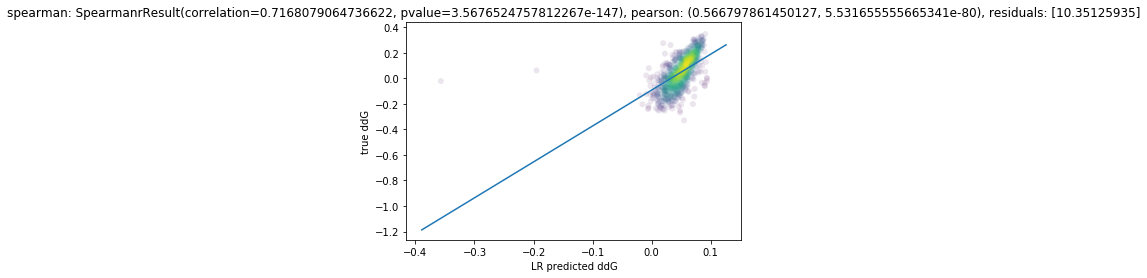

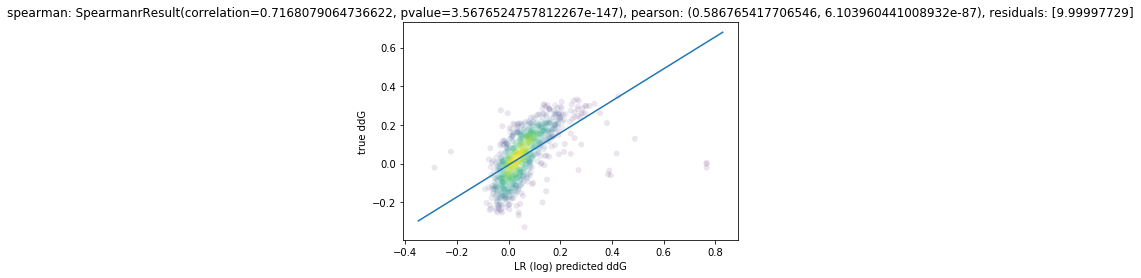

Optimization terminated successfully.
         Current function value: 19985.033600
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 19985.033600
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 19985.033600
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 19985.033600
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 19985.033600
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 19985.033600
         Iterations: 4
         Function evalu

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


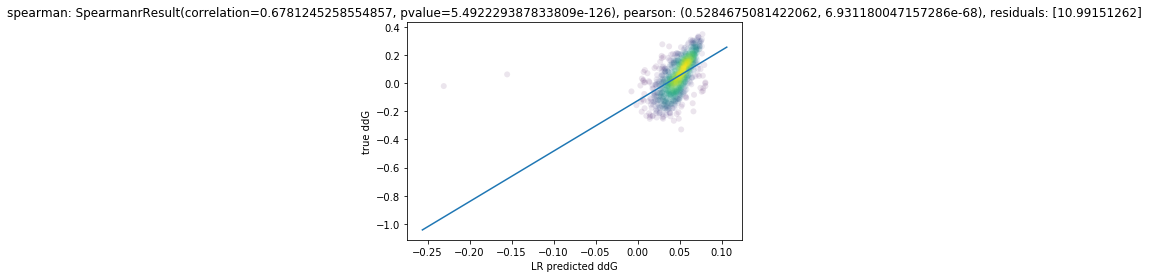

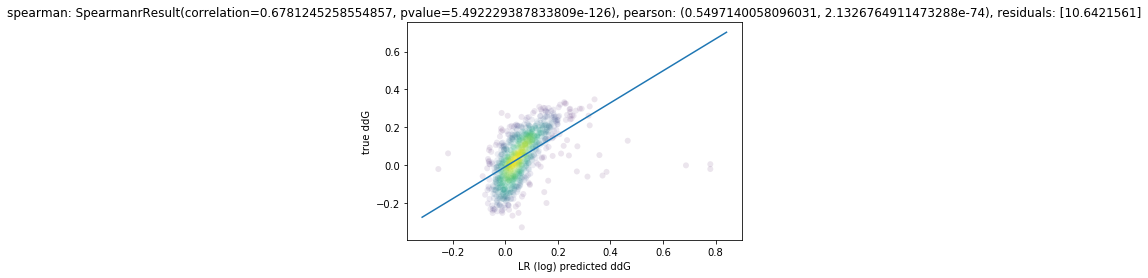

Optimization terminated successfully.
         Current function value: 55867.120000
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 55867.120000
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 55867.120000
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 55867.120000
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 55867.120000
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 55867.120000
         Iterations: 5
         Function 

/users/amr1/miniconda3/envs/basepair/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in log


In [16]:
window_sizes = [16, 32, 48, 64, 128, 256, 546]
for key in tfToBigWigs.keys():
    print(key)
    validFlanks = np.random.choice(list(posFootprint[key].keys()), 50, replace=False)
    validDdGs = getDDGs(key, validFlanks)
    ddGs = getDDGs(key, list(posFootprint[key].keys()))
    for window in window_sizes:
        print(window)
        start = int((seq_len/2)-(window/2))
        end = int((seq_len/2)+(window/2))
        counts = []
        for flank in posFootprint[key]:
            counts.append(np.sum(posFootprint[key][flank][start:end]+ \
                                 negFootprint[key][flank][start:end]))
        counts = np.array(counts)
        validCounts = []
        for flank in validFlanks:
            validCounts.append(np.sum(posFootprint[key][flank][start:end]+ \
                                      negFootprint[key][flank][start:end]))
        validCounts = np.array(validCounts)
        
        # LR counts
        lr = LinearRegression()
        calibration_func = lr(validCounts, validDdGs)
        calibrated_labels = calibration_func(counts)
        plotCorrs(calibrated_labels, ddGs, "LR predicted ddG", "true ddG")
        
        # LR log counts
        lr = LinearRegression()
        calibration_func = lr(np.log(1+validCounts), validDdGs)
        calibrated_labels = calibration_func(np.log(1+counts))
        plotCorrs(calibrated_labels, ddGs, "LR (log) predicted ddG", "true ddG")
        
        # sigmoid fit counts
        sf = SigmoidFit()
        calibration_func, inv_func = sf(validCounts, validDdGs)
        calibrated_labels = inv_func(counts)
        if np.isnan(calibrated_labels).any(): continue
        plotCorrs(calibrated_labels, ddGs, "SF predicted ddG", "true ddG")
        
        # sigmoid fit log counts
        sf = SigmoidFit()
        calibration_func, inv_func = sf(np.log(1+validCounts), validDdGs)
        calibrated_labels = inv_func(np.log(1+counts))
        if np.isnan(calibrated_labels).any(): continue
        plotCorrs(calibrated_labels, ddGs, "SF (log) predicted ddG", "true ddG")